## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST, CIFAR10, EMNIST
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models import resnet18, vgg16
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import copy
from math import floor
import matplotlib.pyplot as plt

## Settings

In [102]:
train_fraction = 1.0
n_clients = 5
distribution = "iid"
alpha = 0.1
train_batch_size = 64
test_batch_size = 64
public_batch_size = 64
public_fraction = 0.5
n_epochs = 3

In [73]:
dataset = EMNIST(
    root='data', 
    train=True, 
    transform=ToTensor(), 
    download=True,
    split='letters')

# means = []
# stds = []
# for img, _ in dataset:
#     means.append(torch.mean(img))
#     stds.append(torch.std(img))

# mean = torch.mean(torch.tensor(means))
# std = torch.mean(torch.tensor(stds))

In [74]:
n_classes = len(np.unique(dataset.targets))
n_classes

26

## Data loaders

In [98]:
def split_train_public(public_fraction, transform):
    """ 
    """
    train_data = EMNIST(
        root='data', 
        train=True, 
        transform=transform, 
        download=True,
        split='letters')

    if not torch.is_tensor(train_data.targets):
        train_data.targets = torch.tensor(train_data.targets)
    train_data.targets = train_data.targets-1

    idx_split = int(len(train_data) * public_fraction)
    
    print(f"Train: {len(train_data)-idx_split}, Public: {idx_split}")

    return Subset(train_data, np.arange(idx_split)), Subset(train_data, np.arange(idx_split, len(train_data)))

# Emnist
transform = Compose([ToTensor(), Normalize((0.1722,), (0.3242,))])
# transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
# transform = Compose([ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
# transform = Compose([ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_data, public_data = split_train_public(public_fraction, transform)


Train: 62400, Public: 62400


In [99]:
def generate_client_data(n_clients, distribution, alpha):
    """ Generate iid client data or non-iid by sampling from Dirichlet distribution.

        Parameters:
        n_clients       (int): Number of clients.
        distribution    (str): Indicator to sample iid or non-iid.
        alpha           (float): Concentration parameter for Dirichlet distribution.
    """
    labels = np.array([train_data[i][1] for i in range(len(train_data))])
    n_classes = len(np.unique(labels))
    partition_matrix = np.ones((n_classes, n_clients))

    # iid: Sample from each class until no samples left.
    if distribution == "iid":
        partition_matrix /= n_clients
        local_sets_indices = [np.array([], dtype=int) for _ in range(n_clients)]
        clients_iter = np.arange(n_clients)

        for i in range(n_classes):
            class_indices = np.where(labels == i)[0]

            clients_iter = clients_iter[::-1]
            samples_left = True
            while samples_left:
                for j in clients_iter:
                    if len(class_indices) == 0:
                        samples_left = False
                        break
                    else:
                        sample_idx = np.random.choice(len(class_indices))
                        local_sets_indices[j] = np.append(local_sets_indices[j], train_data.indices[class_indices[sample_idx]])
                        class_indices = np.delete(class_indices, sample_idx)

    # non-iid: Sample from dirichlet distribution.
    else:
        class_indices = []
        for i in range(n_classes):
            class_indices.append(np.array(range(len(labels)))[labels == i])
        valid_pm = False
        while not valid_pm:
            partition_matrix = np.random.dirichlet((alpha, )*n_clients, n_classes)
            valid_pm = all(np.sum(partition_matrix, axis=0) > 0.01)

        local_sets_indices = [[] for _ in range(n_clients)]
        for each_class in range(n_classes):
            sample_size = len(class_indices[each_class])
            for client in range(n_clients):
                np.random.shuffle(class_indices[each_class])
                local_size = floor(partition_matrix[each_class, client] * sample_size)
                local_sets_indices[client] += list(train_data.indices[class_indices[each_class][:local_size]])
                class_indices[each_class] = class_indices[each_class][local_size:]
    
    return local_sets_indices


local_sets_indices = generate_client_data(n_clients, distribution, alpha)


def get_train_data_loaders(batch_size):
    """ Get list of client training data loaders.

        Parameters:
        n_clients       (int): Number of clients.
        distribution    (str): iid/non-iid distributed data.
        alpha           (float): Concentration parameter for dirichlet distribution.
        batch_size      (int): Batch size for loading training data.

        Returns List[torch.utils.data.DataLoader]
    """
    client_data_loaders = []
    for client_indices in local_sets_indices:
            np.random.shuffle(client_indices)
            client_data_loaders.append(DataLoader(Subset(train_data.dataset, client_indices), batch_size))
    return client_data_loaders

client_data_loaders = get_train_data_loaders(train_batch_size)


In [12]:
len(client_data_loaders[0].dataset)

24000

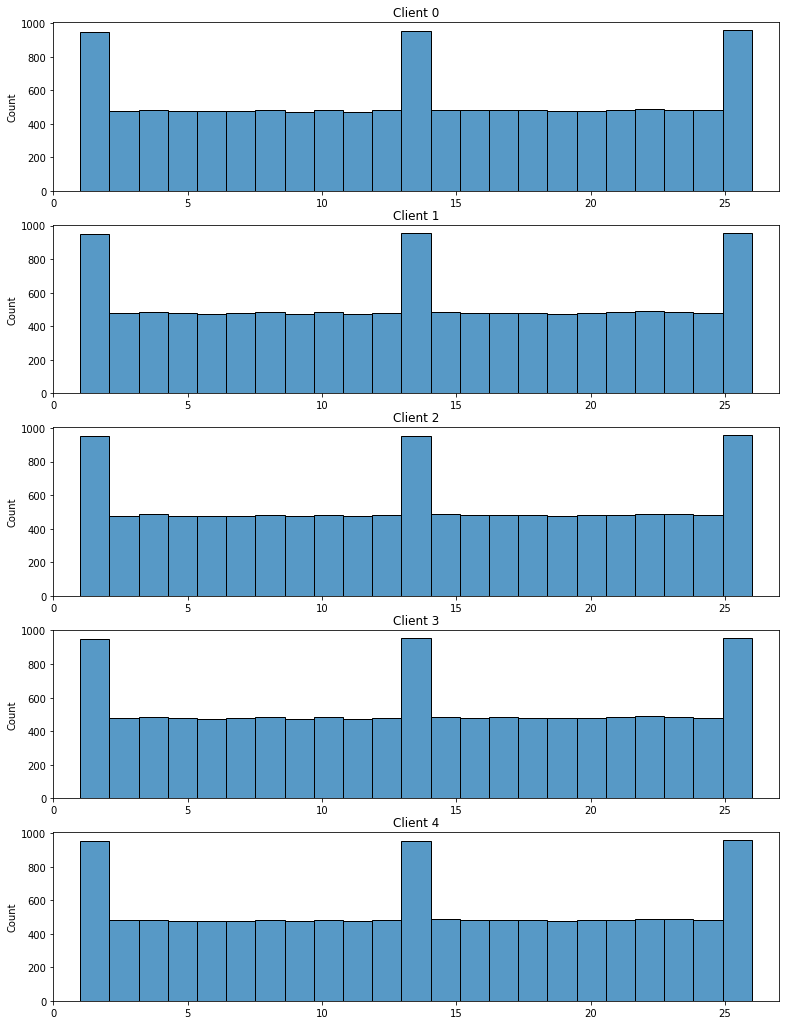

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
dataset = EMNIST(root='data', transform=transform, train=True, split='letters')
#dataset.targets = torch.tensor(dataset.targets)
client_targets = [dataset.targets[indices].tolist() for indices in local_sets_indices]
n_clients = len(client_targets)

fig, ax = plt.subplots(n_clients, figsize=(13,18))
for i in range(n_clients):
    sns.histplot(client_targets[i], ax=ax[i])
    ax[i].set_title("Client {}".format(i))
    ax[i].set_xlim([0,27])

In [86]:
test_data = EMNIST(
    root='data', 
    train=False, 
    transform=transform, 
    download=True,
    split='letters')
test_data.targets = test_data.targets-1

test_data_loader = DataLoader(test_data, test_batch_size)
public_data_loader = DataLoader(public_data, public_batch_size)

In [65]:
len(test_data)

20800

(0.0, 27.0)

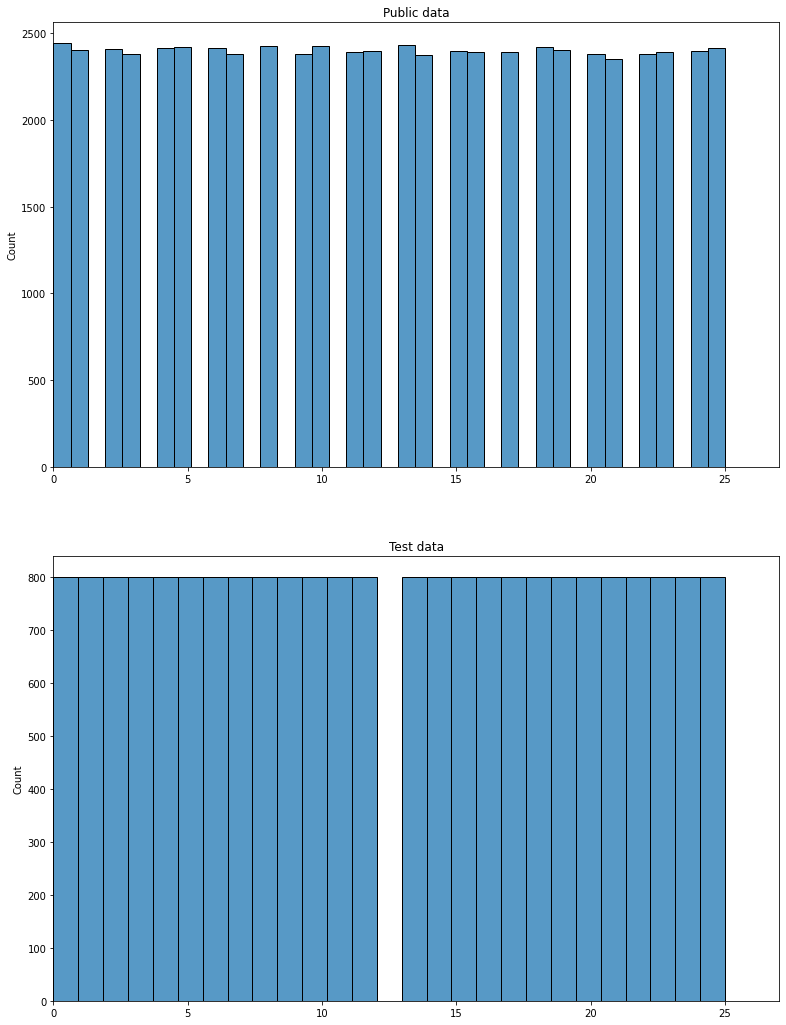

In [87]:
public_targets = public_data.dataset.targets[public_data.indices].tolist()
test_targets = test_data.targets.tolist()

fig, ax = plt.subplots(2, figsize=(13,18))

sns.histplot(public_targets, ax=ax[0])
ax[0].set_title("Public data")
ax[0].set_xlim([0,27])

sns.histplot(test_targets, ax=ax[1])
ax[1].set_title("Test data")
ax[1].set_xlim([0,27])

## Models

In [25]:
class Mnist_Cnn(nn.Module):
    def __init__(self):
        super(Mnist_Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 5, 1, 2)
        self.pool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(2 * 7 * 7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
class Mnist_Student(nn.Module):
    def __init__(self):
        super(Mnist_Student, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [41]:
class Emnist_Cnn(nn.Module):
    def __init__(self):
        super(Emnist_Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 5, 1, 2)
        self.pool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(2 * 7 * 7, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
class Emnist_Student(nn.Module):
    def __init__(self):
        super(Emnist_Student, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 7 * 7, 26)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [57]:
class Cifar10_Cnn(nn.Module):
    def __init__(self):
        super(Cifar10_Cnn, self).__init__()
        base = vgg16(pretrained=False)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.classifier[0].in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
    
class Cifar10_Student(nn.Module):
    def __init__(self):
        super(Cifar10_Student, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training clients

In [90]:
local_indices = [client_data_loaders[i].dataset.indices for i in range(n_clients)]
label_count_matrix = torch.tensor([[torch.sum(client_data_loaders[0].dataset.dataset.targets[local_indices[i]] == c) for c in range(n_classes)] for i in range(n_clients)])
label_count_matrix


tensor([[472, 479, 478, 485, 477, 476, 477, 484, 474, 485, 474, 482, 480, 475,
         484, 481, 481, 482, 475, 480, 484, 491, 484, 482, 480, 478],
        [472, 479, 478, 485, 477, 476, 477, 484, 474, 484, 475, 482, 480, 474,
         485, 481, 482, 482, 476, 480, 484, 491, 484, 482, 480, 477],
        [472, 479, 478, 485, 478, 476, 477, 484, 474, 484, 475, 482, 481, 474,
         485, 480, 482, 481, 476, 480, 484, 490, 485, 482, 480, 477],
        [472, 479, 479, 484, 478, 475, 477, 484, 475, 484, 475, 481, 481, 474,
         485, 480, 482, 481, 476, 479, 484, 490, 485, 481, 480, 477],
        [472, 479, 479, 484, 478, 475, 478, 484, 475, 484, 475, 481, 481, 474,
         485, 480, 482, 481, 476, 479, 484, 490, 485, 481, 481, 477]])

In [91]:
def evaluate(model, data_loader, loss_function):
    model.eval()
    loss = []
    correct = 0
    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            error = loss_function(output, y)
            loss.append(error.item())
            _, pred = torch.max(output.data, 1)
            correct += (pred == y).sum().item()
    avg_loss = sum(loss) / len(loss)
    accuracy = 100. * correct / len(data_loader.dataset)

    return accuracy, avg_loss

In [92]:
local_model = Emnist_Cnn()
loss_function = nn.CrossEntropyLoss()

logits_ensemble = []

print("Starting training")

for i in range(n_clients):
    model = copy.deepcopy(local_model)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(n_epochs):
        train_loss = []
        correct = 0
        model.train()
        for x, y in client_data_loaders[i]:
            optimizer.zero_grad()
            output = model(x)
            error = loss_function(output, y)
            error.backward()
            optimizer.step()
            
            train_loss.append(error.item())
            _, pred = torch.max(output.data, 1)
            correct += (pred == y).sum().item()
        print(f"Client {i+1}/{n_clients}: "
              f"Epoch {epoch+1}/{n_epochs}: "
              f"Train accuracy: {correct/len(client_data_loaders[i].dataset):.2f}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}", end="\r")
    print("\n")
    
    model.eval()
    logits_local = None
    with torch.no_grad():
        for x, _ in public_data_loader:
            if logits_local is None:
                logits_local = F.softmax(model(x), dim=1)
            else:
                logits_local = torch.cat((logits_local, F.softmax(model(x), dim=1)))
        
    # Increment average
    logits_ensemble.append(logits_local)

Starting training
Client 1/5: Epoch 3/3: Train accuracy: 0.56: Train loss: 1.474

Client 2/5: Epoch 3/3: Train accuracy: 0.56: Train loss: 1.482

Client 3/5: Epoch 3/3: Train accuracy: 0.56: Train loss: 1.482

Client 4/5: Epoch 3/3: Train accuracy: 0.57: Train loss: 1.495

Client 5/5: Epoch 3/3: Train accuracy: 0.55: Train loss: 1.502



## Training student

In [93]:
class StudentData(Dataset):
    def __init__(self, dataset):
        
        self.dataset = dataset
            
    def __getitem__(self, index):
        if isinstance(index, list):
            data, _ = self.dataset[[i for i in index]]
        else:
            data, _ = self.dataset[index]
            
        return data, index
        
    
    def __len__(self):
        """Total number of samples"""
        return len(self.dataset)

In [94]:
student_data = StudentData(public_data)
public_loader = DataLoader(student_data, 4, shuffle=True)
x, idx = next(iter(public_loader))

clients = np.random.choice(np.arange(n_clients), int(0.4 * n_clients), replace=False)
chosen_logits = [logits_ensemble[c][idx] for c in clients]
chosen_logits

[tensor([[1.1170e-02, 1.0211e-04, 5.1688e-02, 9.1325e-05, 2.2170e-02, 6.6793e-03,
          1.5590e-03, 2.6207e-04, 3.7554e-03, 9.9320e-04, 5.5561e-03, 2.1069e-03,
          1.3521e-03, 2.5576e-02, 5.6776e-03, 1.4355e-02, 3.5133e-03, 3.7771e-01,
          1.3026e-03, 3.7339e-01, 8.3850e-04, 5.2226e-03, 1.5034e-02, 3.9961e-02,
          1.2004e-02, 1.7933e-02],
         [4.1604e-03, 2.4555e-02, 2.8775e-05, 1.0691e-03, 1.0607e-03, 9.0334e-04,
          4.3738e-04, 4.4377e-01, 5.9317e-04, 4.7429e-06, 3.1275e-01, 2.2289e-03,
          2.4471e-04, 2.7765e-03, 2.6432e-05, 2.8209e-04, 1.1850e-04, 2.5470e-03,
          5.2685e-05, 3.9024e-03, 1.0393e-03, 1.5639e-03, 5.4529e-04, 1.7684e-01,
          1.1136e-03, 1.7381e-02],
         [4.4775e-02, 2.3828e-03, 2.1694e-04, 3.7343e-03, 3.7857e-03, 2.1067e-02,
          5.5010e-04, 1.5422e-02, 1.3190e-04, 9.0940e-05, 4.3062e-02, 2.8939e-05,
          4.0464e-03, 7.7630e-01, 1.7628e-03, 5.6768e-03, 1.9626e-04, 7.6059e-03,
          6.0945e-04, 3.5253

In [116]:
public_data_loader.dataset

In [96]:
def evaluate(model, data_loader, loss_function):
    model.eval()
    loss = []
    correct = 0
    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            error = loss_function(output, y)
            loss.append(error.item())
            _, pred = torch.max(output.data, 1)
            correct += (pred == y).sum().item()
    avg_loss = sum(loss) / len(loss)
    accuracy = 100. * correct / len(data_loader.dataset)

    return accuracy, avg_loss

T = 1
gamma = 0.4
student_batch_size = 50

student_data = StudentData(public_data)
student_loader = DataLoader(student_data, student_batch_size, shuffle=True)

model = Emnist_Student()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for t in range(T):
    model.train()
    for x, idx in student_loader:
        clients = np.random.choice(np.arange(n_clients), int(0.4 * n_clients), replace=False)
        merged_logits = torch.zeros(student_batch_size, len(classes))
    
        for c in clients:
            merged_logits += logits_ensemble[c][idx] * torch.sum(label_count_matrix[c]) / torch.sum(torch.sum(label_count_matrix[clients]))
        
        optimizer.zero_grad()
        output = model(x)
        error = loss_function(output, merged_logits)
        error.backward()
        optimizer.step()
        
    train_acc, train_loss = evaluate(model, public_data_loader, nn.CrossEntropyLoss())
    print(f"Distillation step {t+1}/{T}: "
          f"Train accuracy: {train_acc:.2f}: "
          f"Train loss: {train_loss:.3f}", end="\r")
print("\n")

Distillation step 1/1: Train accuracy: 65.54: Train loss: 2.961



In [59]:
student_targets = torch.zeros(len(test_data.dataset), 10)
for i in range(n_samples_public):
    idx_public = public_data.indices[i]
    student_targets[idx_public] = logits_ensemble[i]

In [60]:
class StudentData(Dataset):
    def __init__(self, dataset, targets):
        
        self.dataset = dataset
        self.targets = targets
        self.indices = dataset.indices
            
    def __getitem__(self, index):
        if isinstance(index, list):
            data, _ = self.dataset[[i for i in index]]
            target = self.targets[[self.indices[i] for i in index]]
        else:
            data, _ = self.dataset[index]
            target = self.targets[self.indices[index]]
            
        return data, target
        
    
    def __len__(self):
        """Total number of samples"""
        return len(self.indices)

student_data = StudentData(public_data, student_targets)
student_data_loader = DataLoader(student_data, public_batch_size)
data_iter = iter(student_data_loader)
next(data_iter)

[tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
       

In [64]:
def evaluate(model, data_loader, loss_function):
    model.eval()
    loss = []
    correct = 0
    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            error = loss_function(output, y)
            loss.append(error.item())
            _, pred = torch.max(output.data, 1)
            correct += (pred == y).sum().item()
    avg_loss = sum(loss) / len(loss)
    accuracy = 100. * correct / len(data_loader.dataset)

    return accuracy, avg_loss

model = Mnist_Student()
loss_function = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs_student = 150

for epoch in range(n_epochs_student):

    model.train()
    for x, y in student_data_loader:
        optimizer.zero_grad()
        output = model(x)
        error = loss_function(output, y)
        error.backward()
        optimizer.step()
        
    train_acc, train_loss = evaluate(model, public_data_loader, nn.CrossEntropyLoss())
    print(f"Epoch {epoch+1}/{n_epochs_student}: "
          f"Train accuracy: {train_acc:.2f}: "
          f"Train loss: {train_loss:.3f}", end="\r")
print("\n")
    

Epoch 150/150: Train accuracy: 79.30: Train loss: 1.984



In [97]:
correct = 0
total = 0

with torch.no_grad():
     for x, y in test_data_loader:
            output = model(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total +=1
                
print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.654


In [25]:
alg = "fedavg+feded"
algs = alg.split("+")
ens = ["fede"]

In [27]:
any(alg in algs for alg in ens)

In [28]:
b

False

In [57]:
client_data_loaders[0]